In [ ]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with quantum long short-term memory

This notebook provides a PyTorch implementation of the quantum long short-term memory (QLSTM) algorithm based on Chen, Yoo, and Fang 2020<sup>1</sup> and applies it to time series data.

In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torchinfo import summary
import random
import matplotlib.pyplot as plt
import copy
import pandas as pd

#### Data set for the Bessel function

First, we import the time series data generated by the Bessel function. Our task is to forecast one future value of Bessel data from the past four data points (`seq_length=4`). From $\boldsymbol{x}=\{x_0,x_1,x_2,x_3,x_4,x_5, x_6\dots,\}$, we create the following pairs of $(x, y)$:

$$
\begin{align}
(x_0,x_1,x_2,x_3), &\; x_4 \\
(x_1,x_2,x_3,x_4), &\; x_5 \\
(x_2,x_3,x_4,x_5), &\; x_6 \\
&\vdots
\end{align}
$$

In [2]:
df = pd.read_csv("data/bassel_data_seq_length4.csv")
x = df[["x0", "x1", "x2", "x3"]].values
y = df["y"].values

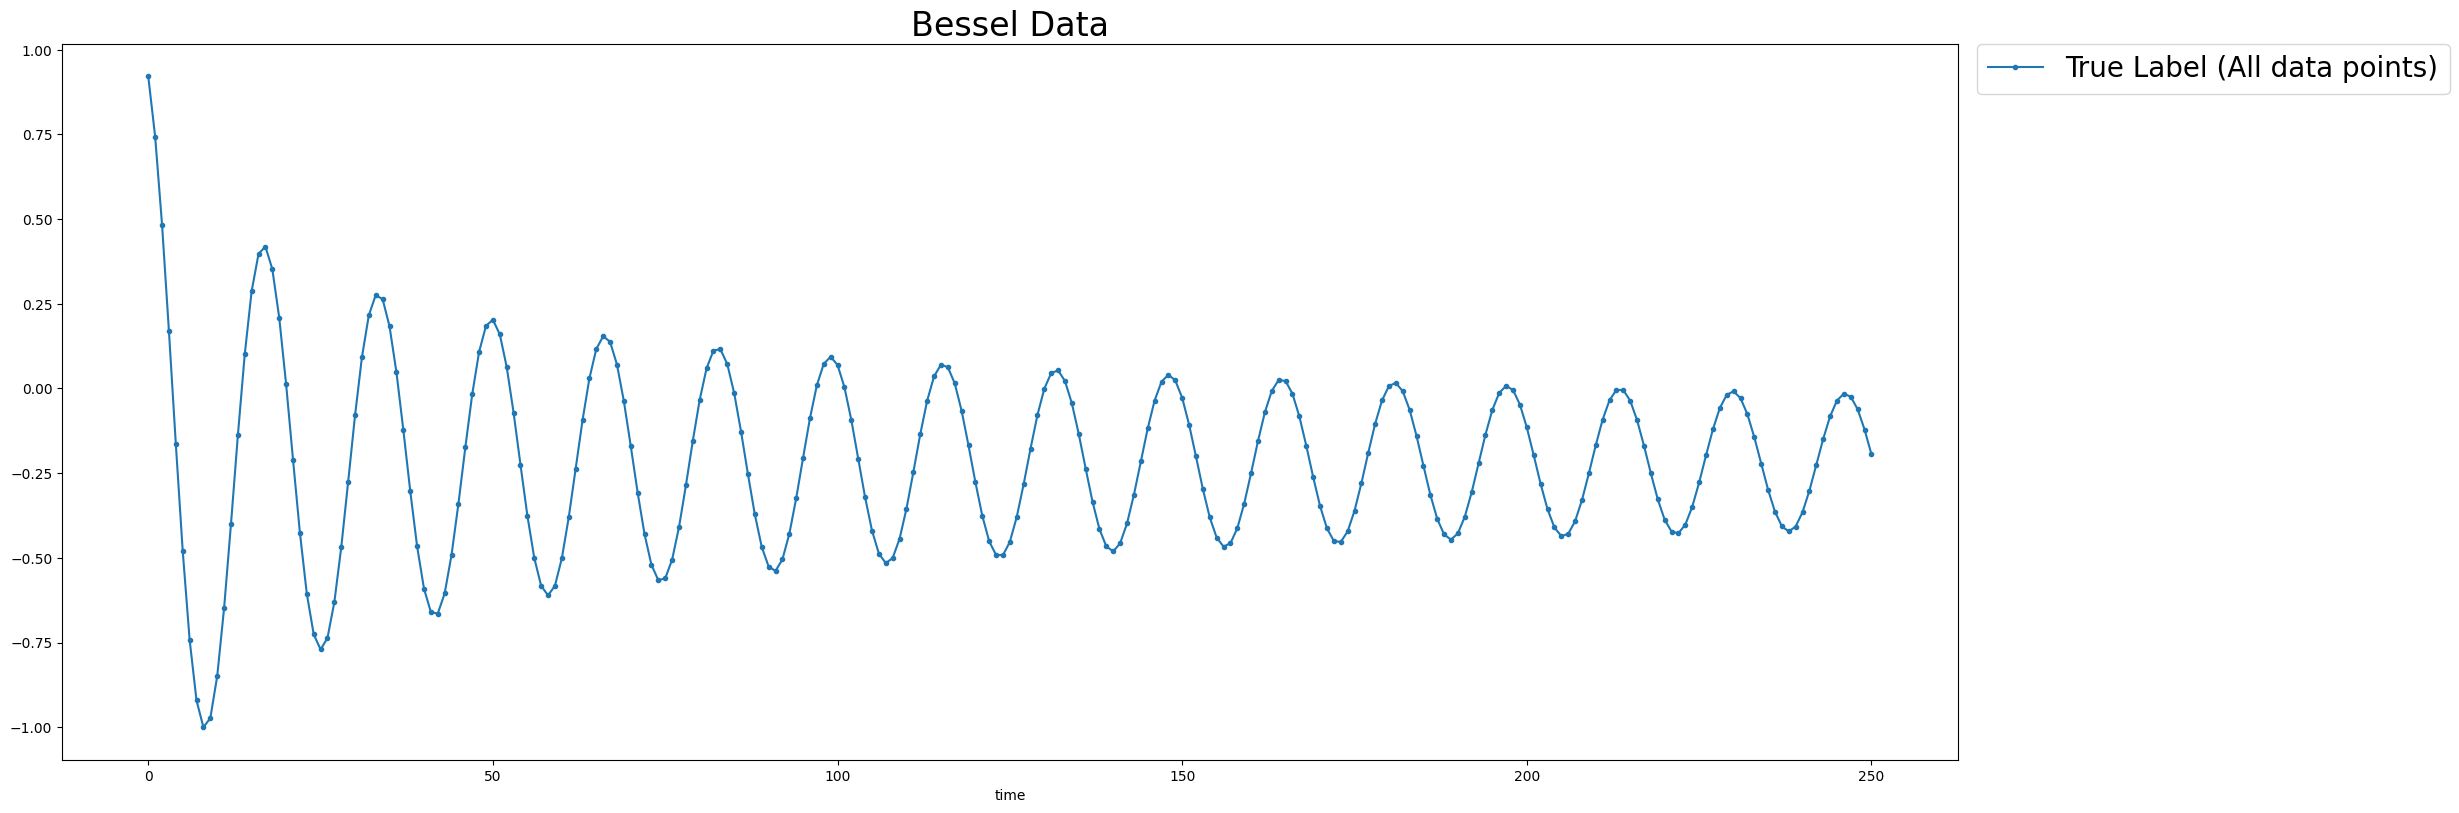

In [3]:
fig, ax = plt.subplots(figsize=(25, 8))
plt.rcParams["font.size"] = 20
ax.plot(y,  marker=".", label="True Label (All data points)")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.title("Bessel Data")
plt.xlabel("time")
plt.show()

In the Bessel function plot above, `x` contains the past four sequences and `y` contains one future value. Let’s look at what’s in the data.

In [4]:
for i in range(10):
    print(i, x[i], y[i])

0 [0.66815706 0.85776397 0.97559798 1.        ] 0.9213836232385187
1 [0.85776397 0.97559798 1.         0.92138362] 0.7436288159581085
2 [0.97559798 1.         0.92138362 0.74362882] 0.4836621172191315
3 [1.         0.92138362 0.74362882 0.48366212] 0.1692835235355315
4 [0.92138362 0.74362882 0.48366212 0.16928352] -0.1644622860030088
5 [ 0.74362882  0.48366212  0.16928352 -0.16446229] -0.4798766737131174
6 [ 0.48366212  0.16928352 -0.16446229 -0.47987667] -0.741538021956348
7 [ 0.16928352 -0.16446229 -0.47987667 -0.74153802] -0.9209085020045256
8 [-0.16446229 -0.47987667 -0.74153802 -0.9209085 ] -1.0
9 [-0.47987667 -0.74153802 -0.9209085  -1.        ] -0.97361393993834


We consider forecasting `y[i]` from `x[i]`. As you can see, `y[i]` is passed to the last element of `x[i+1]`. By slicing in this way, the Bessel data can be decomposed to (`x`, `y`) pairs.

Data set is separated into train and test data sets in past and future time frames. The ratio between train and test data points can be determined by `train_ratio`. We set `train_ratio` to `0.67` in this notebook.

`x` and `y` are converted to the PyTorch data format (`torch.Tensor`). By running `convert_data_for_pytorch`, we can convert the train and test data sets into the PyTorch format.

In [5]:
def convert_data_for_pytorch(x, y, data_size=None, train_ratio=0.67):
    if data_size is None:
        data_size = len(x)
    
    # Reshape for pytorch (Batch, Sequence, Input_Size)
    seq_length = x.shape[1]
    x = x[:data_size].reshape(data_size, seq_length, 1)
    y = y[:data_size].reshape(data_size, 1)

    train_size = int(train_ratio * len(x))

    trainX = torch.Tensor(np.array(x[:train_size]))
    trainY = torch.Tensor(np.array(y[:train_size]))

    testX = torch.Tensor(np.array(x[train_size:]))
    testY = torch.Tensor(np.array(y[train_size:]))
    return trainX, trainY, testX, testY

In [6]:
trainX, trainY, testX, testY = convert_data_for_pytorch(x, y)

Next, we check to see what the Bessel data looks like.

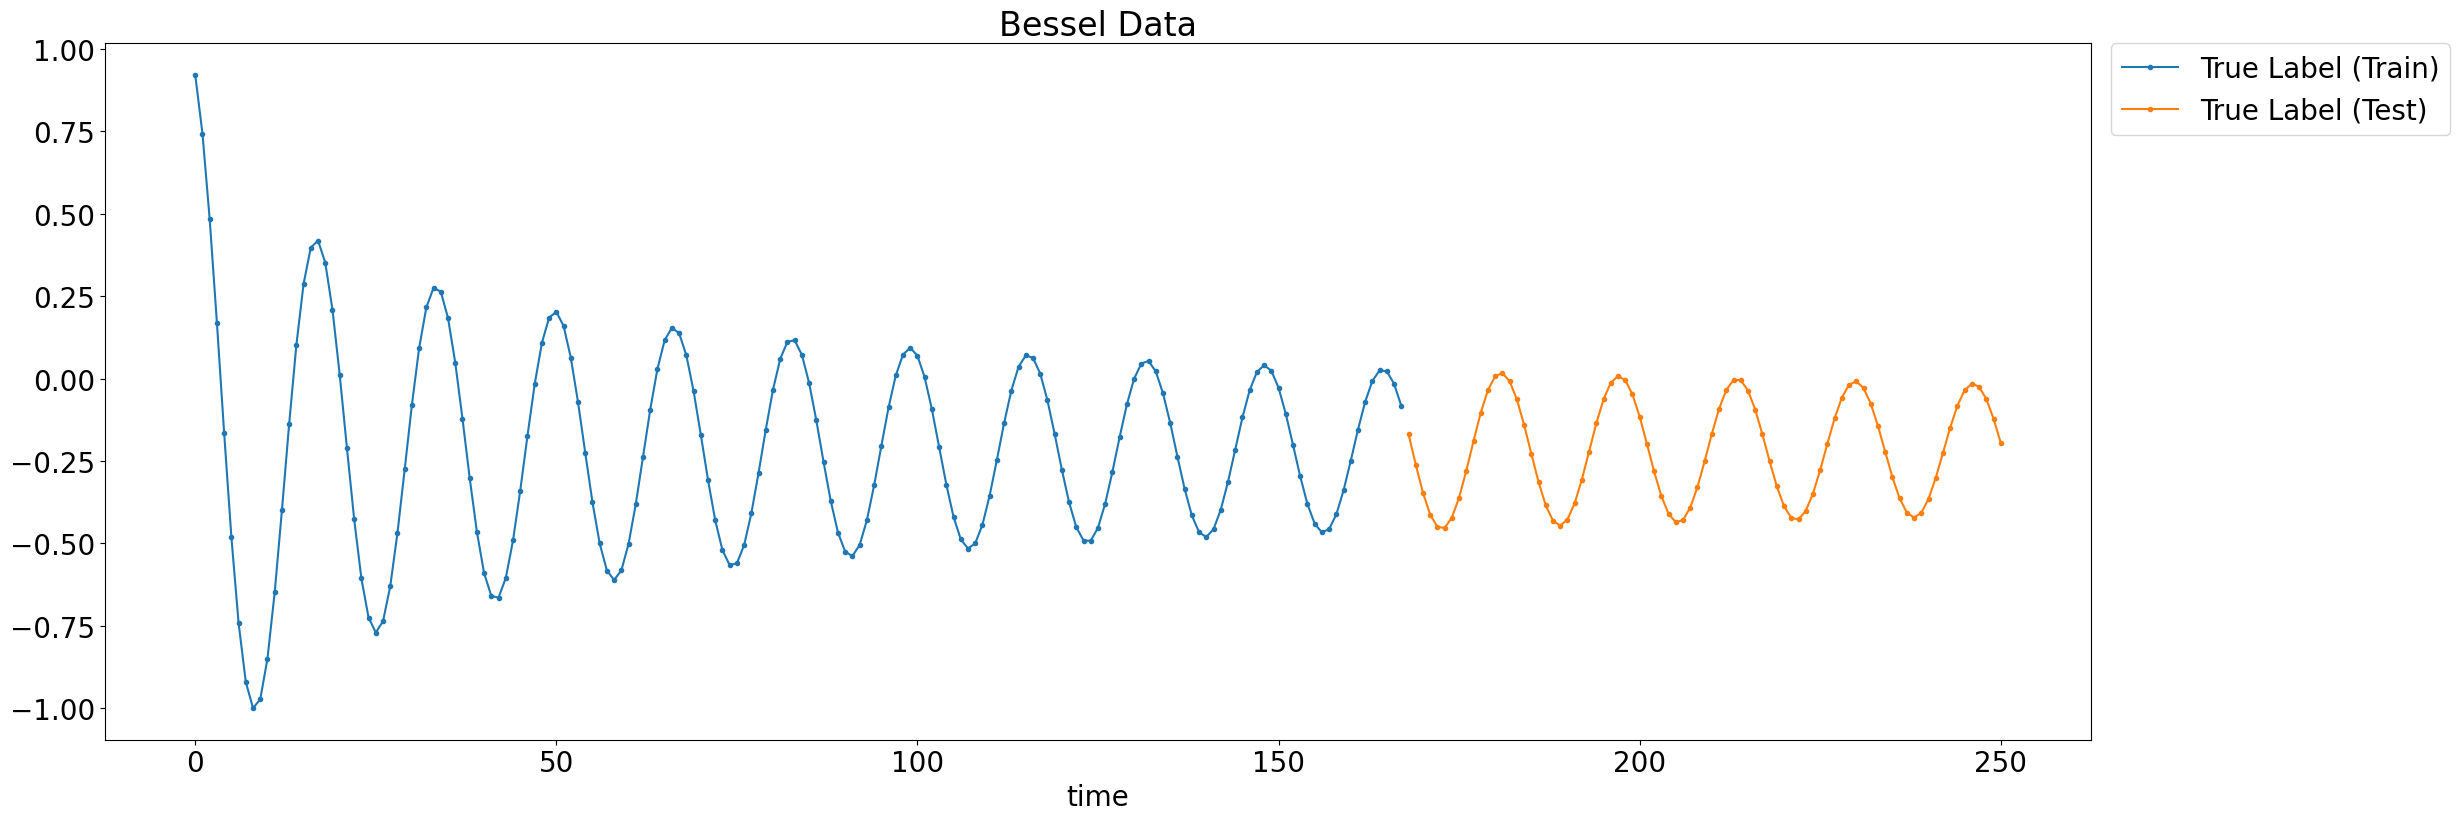

In [7]:
train_range = [i for i in range(len(trainY))]
test_range = [len(trainY) + i for i in range(len(testY))]
fig, ax = plt.subplots(figsize=(25, 8))
plt.rcParams["font.size"] = 20
ax.plot(train_range, trainY.data.numpy(), marker=".", label="True Label (Train)")
ax.plot(test_range, testY.data.numpy(), marker=".", label="True Label (Test)")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.title("Bessel Data")
plt.xlabel("time")
plt.show()

### Classical LSTM

Before describing QLSTM, we review classical LSTM in this section. Recurrent neural networks (RNN) use hidden states to store short-term memory. However, they sometimes fail in tasks with long-term dependencies. Long short-term memory (LSTM) was invented to overcome this difficulty by introducing long-term memory as well as short-term memory. Long-term memory is expressed as cell states in LSTM. The hidden state $h_t$ and cell state $c_t$ are generated from the following equations:

$$
\begin{align}
    f_t &= \sigma(W_f \cdot v_t + b_f) \\
    i_t &= \sigma(W_i \cdot v_t + b_i) \\
    \tilde{C}_t &= \tanh(W_C\cdot v_t + b_C) \\
    c_t &= f_t*c_{t-1} + i_t*\tilde{C}_t\\
    o_t &= \sigma(W_o \cdot v_t + b_o) \\
    h_t &= o_t*\tanh(c_t)
\end{align}
$$

where $\sigma$ denotes the sigmoid function, $\{W_n\}_{n=f,i,C,o}$ are weights of classical fully connected layers, and $\{b_n\}$ are the corresponding biases for $W_n$, $v_t=[h_{t-1},x_t]$, which is an input vector concatenating $h_{t-1}$ and $x_t$. The symbols $*$ and $+$ mean element-wise multiplication and addition, respectively. The network structure of classical LSTM is shown in [Fig. 1](#LSTM).

$f_t$ is called the “forget gate” and $i_t$ is called the “input gate,” respectively. Since $f_t, i_t$ takes values between 0 and 1, $f_t*c_{t-1}$ means how much previous information $c_{t-1}$ will be forgotten from memory and $i_t*\tilde{C}_{t}$ means how much new information $\tilde{C}_{t}$ will be inputted to memory. By adjusting them, LSTM successfully learns long-term dependencies.  

<a id="LSTM"></a>
<img src="figures/LSTM.png" id="LSTM">
Figure 1. Network structure of classical LSTM

First, apply classical LSTM to the Bessel data and check its performance.

#### LSTM module

In [8]:
class LSTM(nn.Module):
    def __init__(self, setting):
        super(LSTM, self).__init__()
        self.input_size = setting["input_size"] 
        self.output_size = setting["output_size"]
        self.hidden_size = setting["hidden_size"]
        self.num_layers = setting["num_layers"]
        self.device = setting["device"]
        self.seed = setting["seed"]
        
        torch_fix_seed(self.seed)
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(self.device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(self.device)
        
        # LSTM Layer
        output, (hn, cn) = self.lstm(x, (h0, c0))
        hn = hn[-1] # for num_layers > 1
        
        # Full-Connected Layer
        out = self.fc(hn)
        return out

In [9]:
# Fix Random Seed
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    torch.backends.cudnn.benchmark = False
    return

#### Run LSTM

##### Set parameters

In [10]:
setting_c = {}
setting_c["input_size"] = 1
setting_c["output_size"] = 1
setting_c["hidden_size"] = 3
setting_c["num_layers"] = 1
setting_c["device"] = torch.device("cpu")
setting_c["batch_first"] = True
setting_c["seed"] =42

# Training Parameters
setting_c["learning_rate"] = 0.1
setting_c["num_epochs"] = 100

##### Train LSTM

In [11]:
losses_c = []
weights_min_c = None
loss_min_c = 10**10
    
model_c = LSTM(setting_c)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_c.parameters(), lr=setting_c["learning_rate"])

for epoch in range(setting_c["num_epochs"]):
    outputs = model_c(trainX.to(model_c.device))
    optimizer.zero_grad()
    loss = criterion(outputs, trainY.to(model_c.device))
    loss.backward()
    optimizer.step()
    losses_c.append(loss.item())
    if loss.item() < loss_min_c:
        loss_min_c = loss.item()
        weights_min_c = copy.deepcopy(model_c.state_dict())

model_c.eval()
model_c.load_state_dict(weights_min_c)
output_train_c = model_c(trainX.to(model_c.device))
loss = criterion(output_train_c, trainY.to(model_c.device))
loss_train_c = loss.item()
print("Train Loss:", loss_train_c)

model_c.eval()
output_test_c = model_c(testX.to(model_c.device))
loss_test_c = criterion(output_test_c, testY.to(model_c.device)).item()
print("Test Loss:", loss_test_c)

Train Loss: 0.0002867182483896613
Test Loss: 5.4139083658810705e-05


##### Training loss of LSTM

In [12]:
model_c.eval()
model_c.load_state_dict(weights_min_c)
output_train_c = model_c(trainX.to(model_c.device))
loss = criterion(output_train_c, trainY.to(model_c.device))
loss_train_c = loss.item()
print("Train Loss:", loss_train_c)

Train Loss: 0.0002867182483896613


##### Test LSTM

In [13]:
model_c.eval()
output_test_c = model_c(testX.to(model_c.device))
loss_test_c = criterion(output_test_c, testY.to(model_c.device)).item()
print("Test Loss:", loss_test_c)

Test Loss: 5.4139083658810705e-05


In [14]:
def get_num_params(model):
    params = 0
    for p in model.parameters():
        if p.requires_grad:
            params += p.numel()
    return int(params)

##### Check the number of LSTM parameters

In [15]:
num_params_c = get_num_params(model_c)
print(num_params_c)

76


In [16]:
summary(model_c)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─LSTM: 1-1                              72
├─Linear: 1-2                            4
Total params: 76
Trainable params: 76
Non-trainable params: 0

##### History of training loss of LSTM

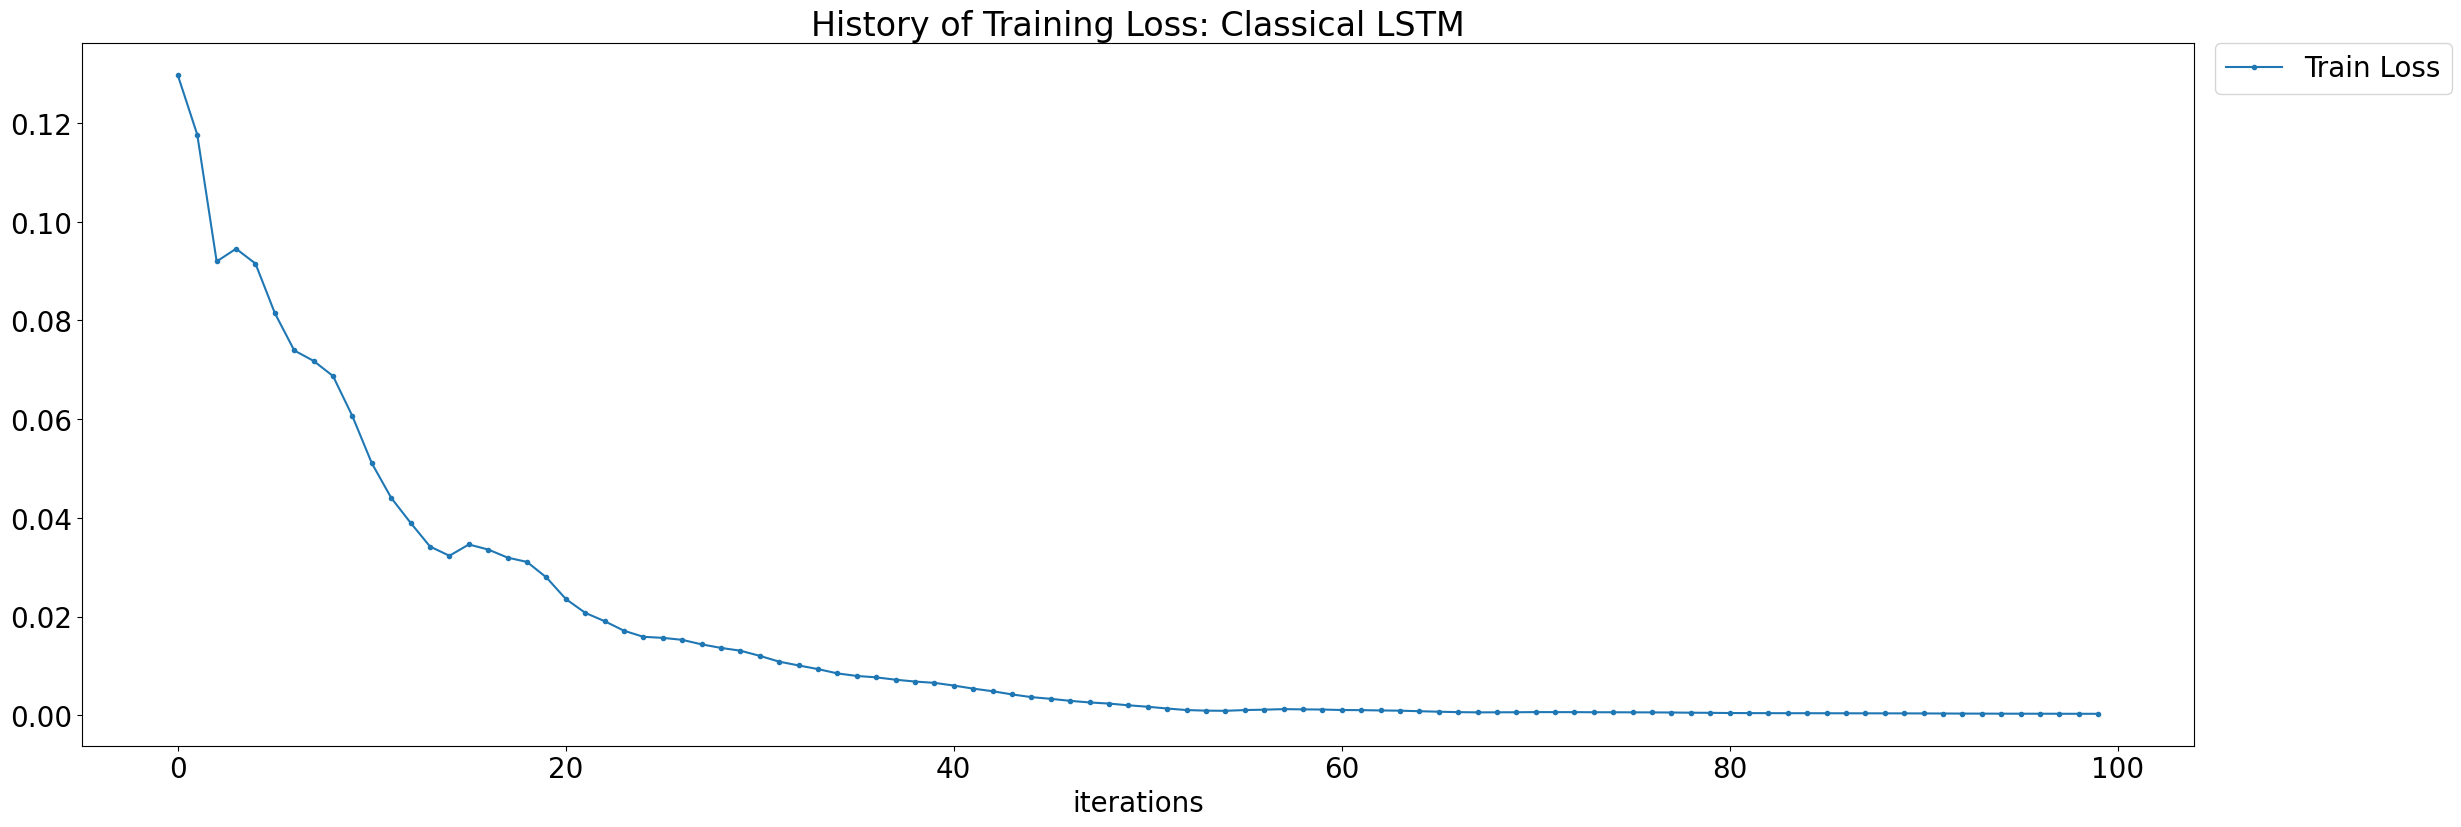

In [17]:
fig, ax = plt.subplots(figsize=(25, 8))
plt.rcParams["font.size"] = 20
ax.plot(losses_c, marker=".", label="Train Loss")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.title("History of Training Loss: Classical LSTM")
plt.xlabel("iterations")
plt.show()

##### Plot data points generated by trained LSTM with train and test data

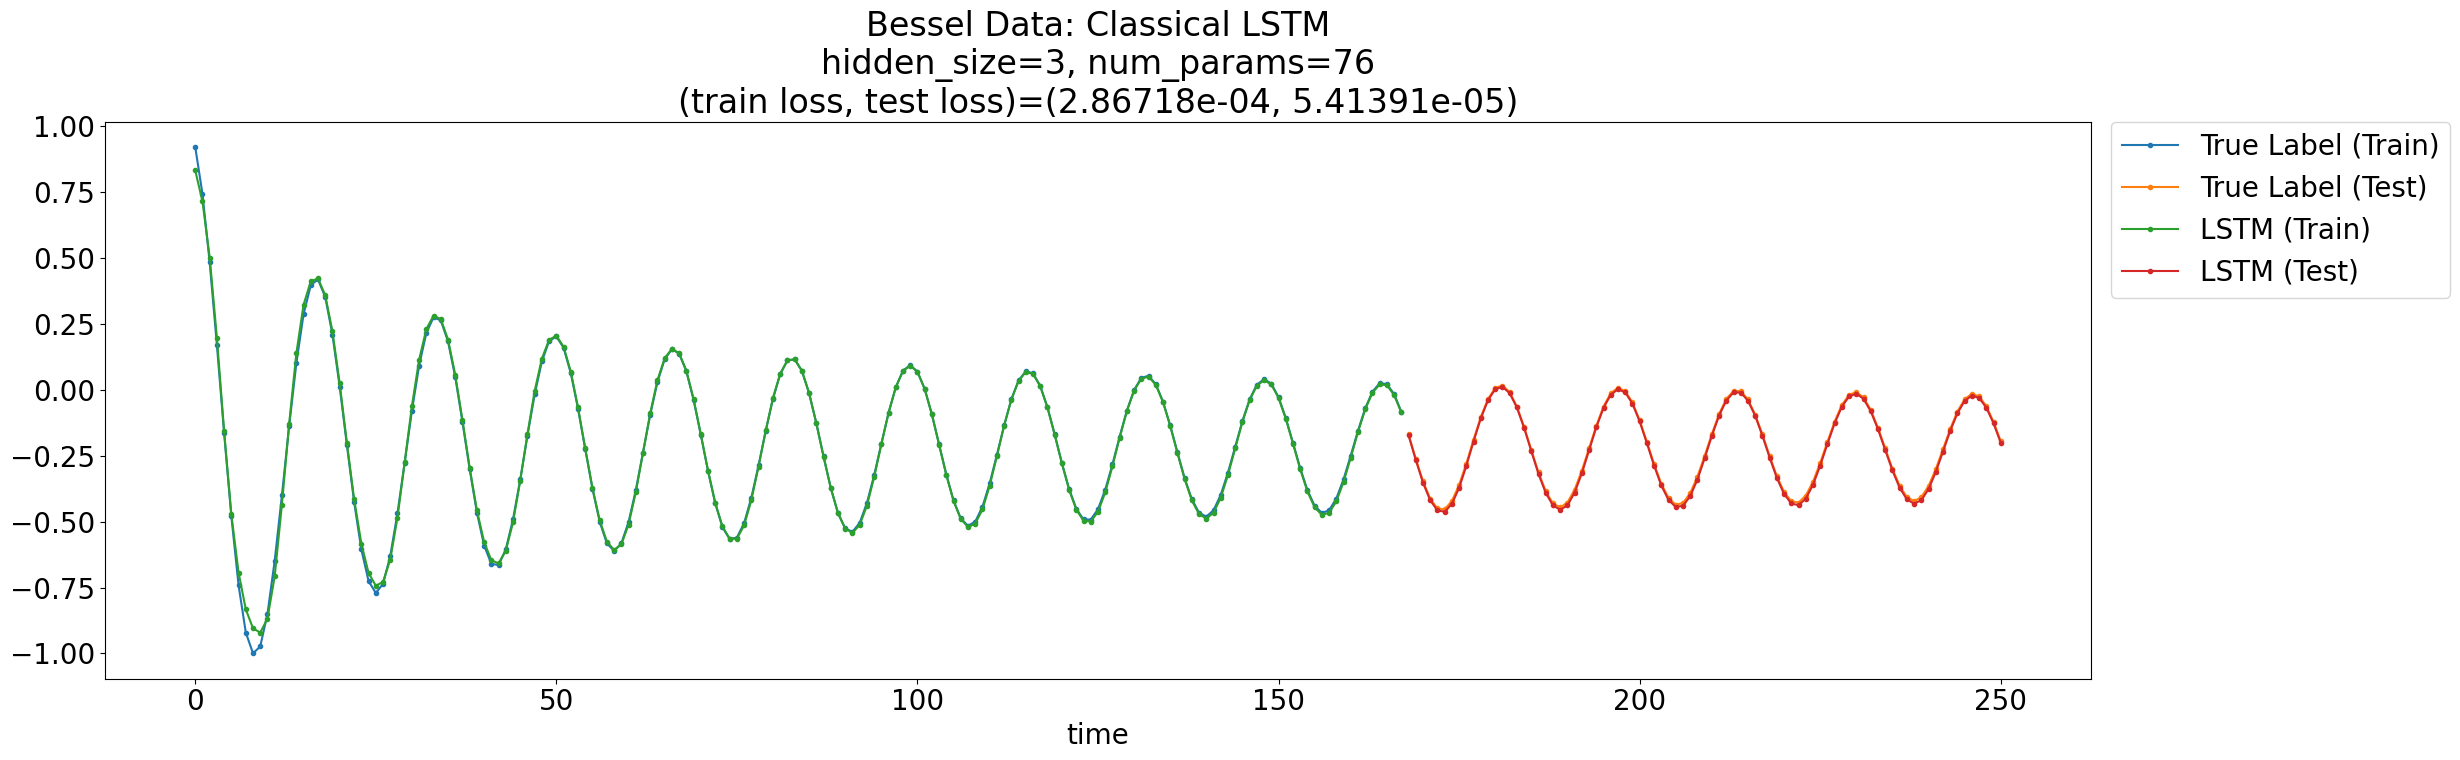

In [18]:
train_range = [i for i in range(len(trainY))]
test_range = [len(trainY) + i for i in range(len(testY))]
fig, ax = plt.subplots(figsize=(25, 8))
plt.rcParams["font.size"] = 20
ax.plot(train_range, trainY.data.numpy(), marker=".", label="True Label (Train)")
ax.plot(test_range, testY.data.numpy(), marker=".", label="True Label (Test)")
ax.plot(train_range, output_train_c.data.numpy(), marker=".", label="LSTM (Train)")
ax.plot(test_range, output_test_c.data.numpy(), marker=".", label="LSTM (Test)")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.title("Bessel Data: Classical LSTM\nhidden_size={}, num_params={}\n(train loss, test loss)=({:.5e}, {:.5e})".format(setting_c["hidden_size"], num_params_c, loss_train_c, loss_test_c))
plt.xlabel("time")
plt.tight_layout()
plt.show()

### Quantum LSTM

Quantum LSTM replaces the classical fully connected layers $W_i$ with the variational quantum circuits (VQC), $VQC_i (i=f,i,C,o)$. The network structure used in this notebook is shown in [Fig. 2](#QLSTM). A fully connected layer $W_i$ is applied to $v_t$, and then $y_t$ is generated so that the number of features of $y_t$ becomes equal to the number of qubits of VQCs.

<a id="QLSTM"></a>
<img src="figures/QLSTM.png" id="QLSTM">
Figure 2. Network structure of quantum LSTM

## Variational Quantum Circuit

<a id="VQC"></a>
<img src="figures/QLSTM_VQC_UV.png" id="VQC" width="80%" height="80%">
Figure 3. Components of a variational quantum circuit

VQC consists of three types of layer, as depicted in [Fig. 3](#VQC): 
1. Data encoding layer (feature map) $U(\boldsymbol{x})$
2. Variational layer $V(\boldsymbol{\theta})$ 
3. Quantum measurement layer

At the $U(\boldsymbol{x})$ layer, input data $\boldsymbol{x}$ is embedded into a quantum circuit with a feature map. $\boldsymbol{x}=\{x_1,x_2,x_3,x_4\}$ is embedded into qubits with $R_y$ and $R_z$ gates (see Fig. 3). 

At the $V(\boldsymbol{\theta})$ layer, the variational parameters $\alpha_i, \beta_i, \gamma_i$ are $R_x$, $R_y$, and $R_z$ gates, respectively, and are applied to the $i$-th qubit. Only $V(\boldsymbol{\theta})$ includes variational parameters that will be optimized during the training process.  

Finally, the quantum measurement layer outputs expectation values of given observables. In this notebook, we set $[Z_1, Z_2,\cdots, Z_n]$ as observables.

#### Quantum gates for PyTorch

In this section, we explore the implementation of basic quantum gates with PyTorch in order to integrate VQCs with PyTorch.  

First, implement one-qubit gates and store them at `Basic_Gates`.

In [19]:
dtype_ = torch.cfloat

# Basic gates for one qubit
I = torch.tensor([[1, 0], [0, 1]], dtype=dtype_)
X = torch.tensor([[0, 1], [1, 0]], dtype=dtype_)
Y = torch.tensor([[0, -1j], [1j, 0]], dtype=dtype_)
Z = torch.tensor([[1, 0], [0, -1]], dtype=dtype_)
H = (1/np.sqrt(2))*torch.tensor([[1, 1], [1, -1]], dtype=dtype_)

Basic_Gates = {}
Basic_Gates["X"] = X
Basic_Gates["Y"] = Y
Basic_Gates["Z"] = Z
Basic_Gates["H"] = H

# Multiply imaginary number, i, with each gate
Basic_Gates["X_i"] = 1j*X
Basic_Gates["Y_i"] = 1j*Y
Basic_Gates["Z_i"] = 1j*Z
Basic_Gates["H_i"] = 1j*H

Multi-qubit gates can be defined as the tensor products of one-qubit gates. 

For example, in the case of a three-qubit system, $X_1$ can be defined as $I_0 \otimes X_1 \otimes I_2$, where $\otimes$ means a tensor product. A tensor product $X \otimes Y$ can be constructed by using `torch.kron(X, Y)`. The function `make_QuantumGates(num_qubits)` generates multi-qubit gates, where `num_qubits` means the total number of qubits. You can refer to $X_1$ by accessing `QuantumGates["X", 1]`. Note that `H_all` means $H_0 \otimes H_1 \otimes \cdots \otimes H_n$. 

In [20]:
def make_QuantumGates(num_qubits):    
    QuantumGates = {}
    # X, Y, Z, H for multi-qubits space
    for key, gate in Basic_Gates.items():
        for q in range(num_qubits):
            gate_list = [I for i in range(num_qubits)]
            gate_list[q] = gate
            temp = gate_list[0]
            for g in gate_list[1:]:
                temp = torch.kron(g, temp)
            QuantumGates[key, q] = temp
    
    # H_all
    temp = torch.eye(2**num_qubits, dtype=dtype_)
    for i in range(num_qubits):
        temp = torch.matmul(QuantumGates["H", i], temp)
    QuantumGates["H_all"] = temp
    
    return QuantumGates

In [21]:
num_qubits = 3
QG = make_QuantumGates(num_qubits)

In [22]:
QG["X", 1]

tensor([[0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])

In [23]:
# Check the commutation relation
QG["X", 1]@QG["Y", 1] - QG["Y", 1]@QG["X", 1] == 2j*QG["Z", 1]

tensor([[True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True]])

Next, consider how to implement CNOT gates for a multi-qubit system.  

In the case of a two-qubit system, $CNOT_{0, 1}$ can be defined as 
$$
CNOT_{0, 1} = I_1 \otimes |0\rangle \langle0|_0 + X_1 \otimes |1\rangle \langle1|_0,
$$
where $0$ is the control qubit and $1$ is the target qubit.

By inserting identity gates inside and outside of control and target qubits, we can implement CNOT gates for all combinations of controlled and target qubits. `CNOT(i, j, num_qubits)` can generate $CNOT_{i, j}$ for the `num_qubits` system.

In [24]:
def CNOT(i, j, num_qubits):
    # CNOT_{i, j} = I_j*|0><0|_i + X_j*|1><1|_i
    c0 = torch.tensor([[1, 0], [0, 0]], dtype=dtype_)
    c1 = torch.tensor([[0, 0], [0, 1]], dtype=dtype_)
    gate_list0 = [I for _ in range(num_qubits)]
    gate_list1 = [I for _ in range(num_qubits)]
    gate_list0[i] = c0
    gate_list1[i] = c1
    gate_list1[j] = X
    C0 = gate_list0[0]
    C1 = gate_list1[0]
    for k in range(num_qubits-1):
        C0 = torch.kron(gate_list0[k+1], C0)
        C1 = torch.kron(gate_list1[k+1], C1)
    
    return C0 + C1

Finally, let’s look at how to implement rotation gates.

$R_{P_i}(\theta)$ can be defined as 
$$
R_{P_i}(\theta) = exp(-i\theta/2*P_i) = cos(\theta/2)*I_i - sin(\theta/2)*P_i,

$$
where $P$ can be one of the Pauli operators.

By inserting the above gates at the $i$-th qubit and identity gates otherwise, we can implement rotation gates.

There are times when we would like to apply some rotation gates to the same qubit sequentially such as $R_{X_1}(\alpha) R_{Y_1}(\gamma) R_{Z_1}(\beta)$. We do this operation by inputting `Rtype_list` and `theta_list` in `RotationGate`. If you would like to produce $R_{X_1}(0.1) R_{Y_1}(0.2) R_{Z_1}(0.3)$ for a three-qubit system, please set the following values to `RotationGate`:
- `q=1`: Target qubit index
- `Rtype_list=["X", "Y", "Z"]`: Types of rotation gates (`X` or `Y` or `Z`)
- `theta_list=[0.1, 0.2, 0.3]`: List of parameters to be assigned
- `num_qubits=3`: The total number of qubits

In [25]:
def RotationGate(q, Rtype_list, theta_list, num_qubits):
    # R_P(\theta) = exp(-i\theta/2*P) = cos(\theta/2)*I - sin(\theta/2)*P
    r = torch.eye(2, dtype=dtype_)
    for i, Rtype in enumerate(Rtype_list):
        theta = theta_list[i]*0.5
        r_ = torch.cos(theta)*I - torch.sin(theta)*Basic_Gates[Rtype+"_i"]
        r = torch.matmul(r_, r)
    gate_list = [I for i in range(num_qubits)]
    gate_list[q] = r
    R = gate_list[0]
    for g in gate_list[1:]:
        R = torch.kron(g, R)
        
    return R

Everything is ready. Let’s implement VQC step by step using those quantum gates.

#### Data encoding layer

`make_featuremap` generates the data encoding layer $U(x)$ at [Figure3](#VQC).  

- `inputs`: input values assigned for each qubit
- `num_reps_qfeature`: The number of repitition of this layer.

Since $R_Y$ and $R_Z$ are applied to each qubit at [Figure3](#VQC), we set `Rtype_list=["Y", "Z"]` in `featuremap`.  
`theta_list` is generated by applying arctan such as `[torch.arctan(inputs[i]), torch.arctan(inputs[i]**2)]`.

In [26]:
def make_featuremap(num_qubits, inputs, QuantumGates, num_reps_qfeature):
    fm = torch.eye(2**num_qubits, dtype=dtype_)
    Rtype_list = ["Y", "Z"]
    for r in range(num_reps_qfeature):
        fm = torch.matmul(QuantumGates["H_all"], fm)
        for i in range(num_qubits):
            theta_list = [torch.arctan(inputs[i]), torch.arctan(inputs[i]**2)]
            fm = torch.matmul(RotationGate(i, Rtype_list, theta_list, num_qubits), fm)

    return fm

#### Variational layer

The function `make_ansatz` generates the variational layer $V(\theta)$ in [Fig. 3](#VQC).  

In [27]:
def make_ansatz(num_qubits, weights, num_reps_qansatz, CNOT_):
    ansatz = torch.eye(2**num_qubits, dtype=dtype_)
    Rtype_list = ["X", "Y", "Z"]
    for r in range(num_reps_qansatz):
        for cx in CNOT_.values():
            ansatz = torch.matmul(cx, ansatz)
        for i in range(num_qubits):
            theta_list = [weights[i*3+k] for k in range(3)]
            ansatz = torch.matmul(RotationGate(i, Rtype_list, theta_list, num_qubits), ansatz)
    
    return ansatz

CNOT gates are applied to every pair of qubits with a fixed neighbor whose distance is less than 3 (in a cyclic way).

In [28]:
def make_CNOT_pairs(num_qubits, num_max_intervals=2):
    cq = 0
    tq = -1
    now_intervals  = 1
    CNOT_pairs = []
    while True:
        tq = (cq + now_intervals) % num_qubits
        if cq == tq:
            break
        CNOT_pairs.append((cq, tq))
        cq += 1
        cq = cq % num_qubits
        if cq == 0:
            now_intervals += 1
            if now_intervals >  num_max_intervals:
                break
                
    return CNOT_pairs

We can generate the entire VQC using `make_featuremap` and `make_ansatz`. The measurement layer is applied at the end of the code where Pauli $Z$ expectation values for each qubit are measured.

In [29]:
def make_VQC(num_qubits, inputs, featuremap, _ansatz, QuantumGates, num_reps_qfeature, num_reps_qansatz, Z_all):
    _featuremap = featuremap(num_qubits, inputs, QuantumGates, num_reps_qfeature)
    state = torch.zeros(2**num_qubits, dtype=dtype_)
    state[0] = 1
    state = torch.matmul(_ansatz, torch.matmul(_featuremap, state))
    return torch.sum(state.conj()*torch.matmul(Z_all, state), axis=1).real

#### VQC layer

Finally, incorporate VQC into the PyTorch custom layer.

- `num_qubits`: The number of qubits
- `num_reps_qfeature`: The number of repetitions of the data encoding layer
- `num_reps_qansatz`: The number of repetitions of the variational layer

In [30]:
class VQC_Layer(nn.Module):
    def __init__(
            self,
            num_qubits,
            num_reps_qfeature,
            num_reps_qansatz
        ):
        super().__init__()
        self.num_qubits = num_qubits
        self.Gates = make_QuantumGates(self.num_qubits)
        self.featuremap = make_featuremap
        self.ansatz = make_ansatz
        self.num_reps_qfeature = num_reps_qfeature
        self.num_reps_qansatz = num_reps_qansatz
        self.num_total_vqc_params = self.num_qubits * 3 * self.num_reps_qansatz
        self.weights = nn.Parameter(torch.Tensor(np.random.uniform(0.0, 2.0*np.pi, (self.num_total_vqc_params))))
        self.CNOT_pairs = make_CNOT_pairs(self.num_qubits)
        self.CNOT_ = {(i, j): CNOT(i, j, self.num_qubits) for (i, j) in self.CNOT_pairs}
        self.Z_all = torch.stack([self.Gates["Z", i] for i in range(self.num_qubits)])
        
        return
    
    def forward(self, inputs):
        self.ansatz_ = self.ansatz(self.num_qubits, self.weights, self.num_reps_qansatz, self.CNOT_)
        
        return torch.stack([
                            make_VQC(
                                self.num_qubits,
                                inputs_,
                                self.featuremap,
                                self.ansatz_,
                                self.Gates,
                                self.num_reps_qfeature,
                                self.num_reps_qansatz,
                                self.Z_all)
                            for inputs_ in inputs
                        ]).reshape(len(inputs), -1)

We need four VQC layers, including forget, input, update, output gates as shown in [Fig. 2](#QLSTM).  

#### Network structure of quantum LSTM

[Fig. 4](#QLSTM_Network) shows the whole network structure and how the Bessel data is passed into it. The VQC layers include the forget, input, update, and outpt VQC layers. The final output of VQCs, $h_3$, is passed into the classical fully connected layer so that the number of features of output becomes equal to `y[i]`.  

In this notebook, we set the same value to both `hidden_size` and `num_qubits`, where `hidden_size` means the number of features of $h$ and $c$ states.  

Instead of using sigmoid functions $\sigma$ in [Fig. 3](#QLSTM), we directly map the Pauli $Z$ expectation value $Z\in[-1, 1]$ to $[0, 1]$ by calculating $\frac{Z+1}{2}$ with `map_spin2bit`.

<a id="aQLSTM_Network"></a>
<img src="figures/QLSTM_Networks.png" id="QLSTM_Network" width="100%" height="100%">
Figure 4. The entire network structure of QLSTM

`QLSTM` has the following inputs:

- `input_size`: The number of features of input (= 1)
- `output_size`: The number of features of output (= 1)
- `hidden_size`: The number of features of cell and hidden states
- `num_qubits`: The number of qubits (= `hidden_size`)
- `num_reps_qfeature`: The number of repetitions of the data encoding layer
- `num_reps_qansatz`: The number of repetitions of the variational layer
- `device`: The device type
- `batch_first`: If **`True`**, `batch_size, seq_length, features_size = x.size()`
- `seed`: Random seed used in all PyTorch modules

#### QLSTM module

In [31]:
map_spin2bit = lambda x: (x+1)*0.5
class QLSTM(nn.Module):
    def __init__(self, setting):
        super(QLSTM, self).__init__()
        self.input_size = setting["input_size"] 
        self.output_size = setting["output_size"]
        self.hidden_size = setting["hidden_size"] 
        self.concat_size = self.input_size + self.hidden_size
        self.num_qubits = setting["num_qubits"]
        self.num_reps_qfeature= setting["num_reps_qfeature"]
        self.num_reps_qansatz = setting["num_reps_qansatz"]
        self.device = setting["device"]
        self.batch_first = setting["batch_first"]
        self.seed = setting["seed"]
        
        # Fix all seeds used in PyTorch modules
        torch_fix_seed(self.seed)
        
        # Variational quantum circuits
        self.vqc_forget = VQC_Layer(self.num_qubits, self.num_reps_qfeature, self.num_reps_qansatz)
        self.vqc_input = VQC_Layer(self.num_qubits, self.num_reps_qfeature, self.num_reps_qansatz)
        self.vqc_update = VQC_Layer(self.num_qubits, self.num_reps_qfeature, self.num_reps_qansatz)
        self.vqc_output = VQC_Layer(self.num_qubits, self.num_reps_qfeature, self.num_reps_qansatz)
        
        # Classical fully connected layers
        ## FC for input VQC and output
        self.fc_in = torch.nn.Linear(self.concat_size, self.num_qubits)
        self.fc_final_out = torch.nn.Linear(self.hidden_size, self.output_size)
        
        return
        
    def forward(self, x, init_states=None):
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size).to(self.device)  # hidden state
            c_t = torch.zeros(batch_size, self.hidden_size).to(self.device)  # cell state
        else:
            h_t, c_t = init_states.to(self.device)
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            x_t = x[:, t, :]
            v_t = torch.cat((h_t, x_t), dim=1)
            y_t = self.fc_in(v_t)

            # Apply VQCs for every block
            f_t = map_spin2bit(self.vqc_forget(y_t)) # forget block
            i_t = map_spin2bit(self.vqc_input(y_t)) # input block
            g_t = self.vqc_update(y_t)  # update block
            o_t = map_spin2bit(self.vqc_output(y_t)) # output block
            
            # Update cell state and hidden state
            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

        return self.fc_final_out(h_t)

#### Run QLSTM

It takes about 3 seconds with `num_qubits=2` and 4.5 seconds with `num_qubits=3` for one epoch with a standard laptop.

##### Set parameters

In [32]:
setting_q = {}
setting_q["input_size"] = 1
setting_q["output_size"] = 1
setting_q["hidden_size"] = 3
setting_q["num_qubits"] = setting_q["hidden_size"] 
setting_q["num_reps_qfeature"] = 1
setting_q["num_reps_qansatz"] = 1
setting_q["device"] = torch.device("cpu")
setting_q["batch_first"] = True
setting_q["seed"] =42

# Training parameters
setting_q["learning_rate"] = 0.1
setting_q["num_epochs"] = 100

##### Train QLSTM

In [33]:
losses_q = []
weights_min_q = None
loss_min_q = 10**10
    
model_q = QLSTM(setting_q)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_q.parameters(), lr=setting_q["learning_rate"])

for epoch in range(setting_q["num_epochs"]):
    outputs = model_q(trainX.to(model_q.device))
    optimizer.zero_grad()
    loss = criterion(outputs, trainY.to(model_q.device))
    loss.backward()
    optimizer.step()
    l = loss.item()
    losses_q.append(l)
    if epoch % 10 == 0:
        print(epoch, l)
    if l < loss_min_q:
        loss_min_q = l
        weights_min_q = copy.deepcopy(model_q.state_dict())

0 0.0980382189154625
10 0.09940268844366074
20 0.02925957180559635
30 0.0056710620410740376
40 0.002041826955974102
50 0.0007479522610083222
60 0.0009517651051282883
70 0.0007071844884194434
80 0.00016587578284088522
90 0.00014068740711081773


##### Training loss of QLSTM

In [34]:
model_q.eval()
model_q.load_state_dict(weights_min_q)
output_train_q = model_q(trainX.to(model_q.device))
loss = criterion(output_train_q, trainY.to(model_q.device))
loss_train_q = loss.item()
print("Train Loss:", loss_train_q)

Train Loss: 7.158279186114669e-05


##### Test QLSTM

In [35]:
model_q.eval()
output_test_q = model_q(testX.to(model_q.device))
loss_test_q = criterion(output_test_q, testY.to(model_q.device)).item()
print("Test Loss:", loss_test_q)

Test Loss: 3.534614006639458e-05


##### Check the number of parameters of LSTM

In [36]:
num_params_q = get_num_params(model_q)
print(num_params_q)

55


In [37]:
summary(model_q)

Layer (type:depth-idx)                   Param #
QLSTM                                    --
├─VQC_Layer: 1-1                         9
├─VQC_Layer: 1-2                         9
├─VQC_Layer: 1-3                         9
├─VQC_Layer: 1-4                         9
├─Linear: 1-5                            15
├─Linear: 1-6                            4
Total params: 55
Trainable params: 55
Non-trainable params: 0

##### History of training loss of QLSTM

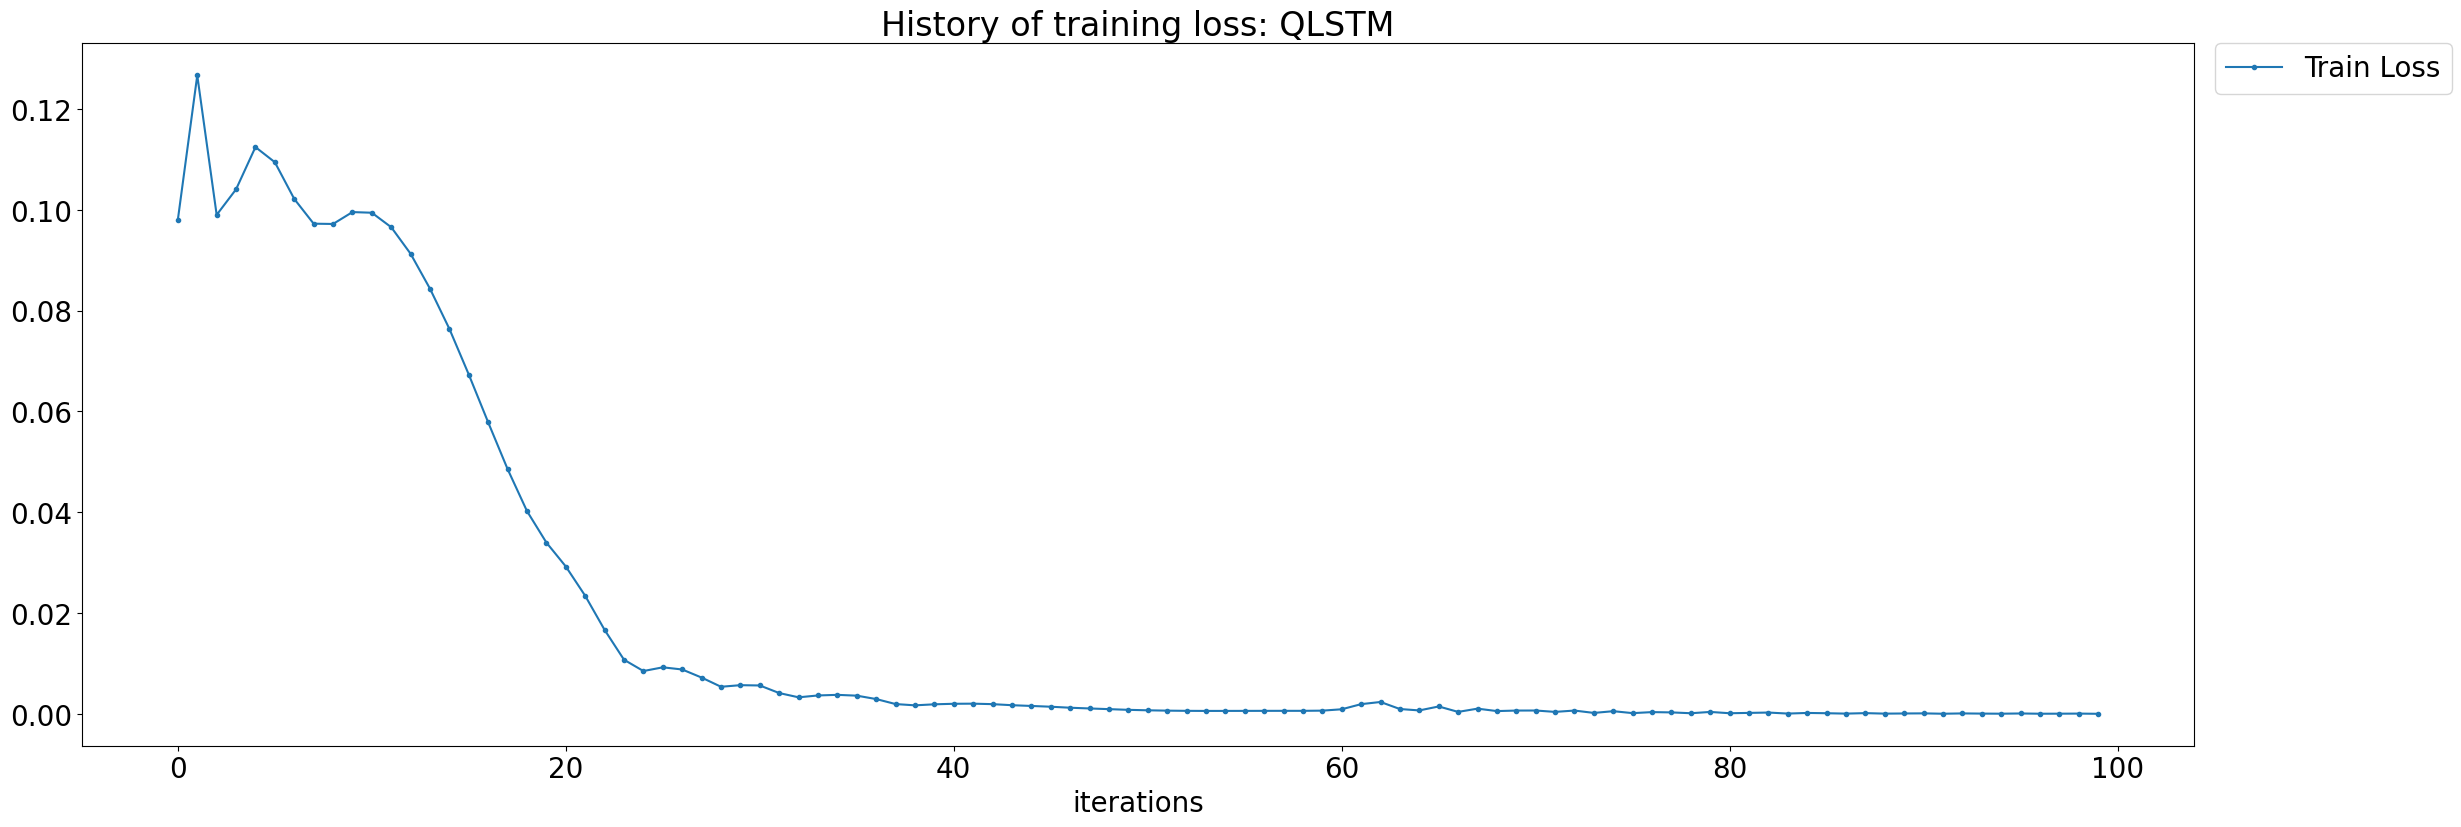

In [38]:
fig, ax = plt.subplots(figsize=(25, 8))
plt.rcParams["font.size"] = 20
ax.plot(losses_q, marker=".", label="Train Loss")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.title("History of training loss: QLSTM")
plt.xlabel("iterations")
plt.show()

##### Plot data points generated by trained LSTM with train and test data

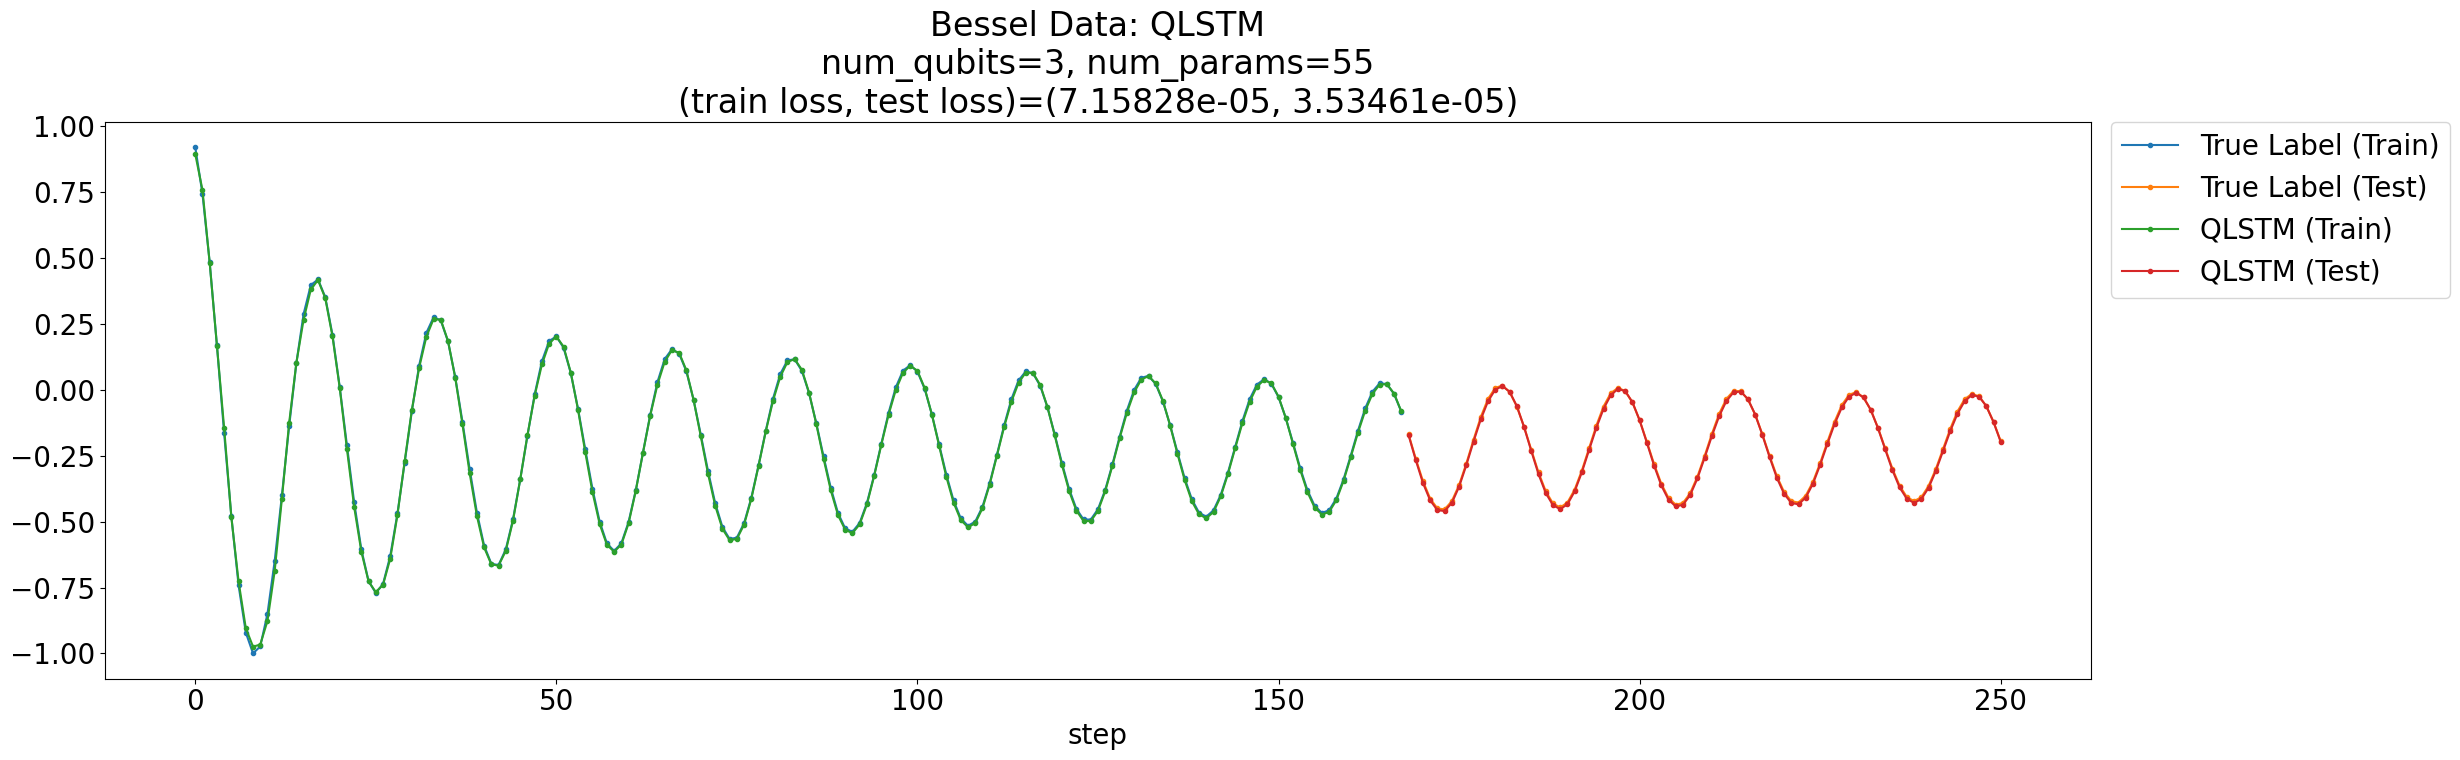

In [39]:
train_range = [i for i in range(len(trainY))]
test_range = [len(trainY) + i for i in range(len(testY))]
fig, ax = plt.subplots(figsize=(25, 8))
plt.rcParams["font.size"] = 20
ax.plot(train_range, trainY.data.numpy(), marker=".", label="True Label (Train)")
ax.plot(test_range, testY.data.numpy(), marker=".", label="True Label (Test)")
ax.plot(train_range, output_train_q.data.numpy(), marker=".", label="QLSTM (Train)")
ax.plot(test_range, output_test_q.data.numpy(), marker=".", label="QLSTM (Test)")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.title("Bessel Data: QLSTM\nnum_qubits={}, num_params={}\n(train loss, test loss)=({:.5e}, {:.5e})".format(setting_q["num_qubits"], num_params_q, loss_train_q, loss_test_q))
plt.xlabel("step")
plt.tight_layout()
plt.show()

### Results

In [40]:
print("LSTM")
print("\tnum_params:", num_params_c)
print("\tTrain Loss:", loss_train_c)
print("\tTest Loss:", loss_test_c)

LSTM
	num_params: 76
	Train Loss: 0.0002867182483896613
	Test Loss: 5.4139083658810705e-05


In [41]:
print("QLSTM")
print("\tnum_params:", num_params_q)
print("\tTrain Loss:", loss_train_q)
print("\tTest Loss:", loss_test_q)

QLSTM
	num_params: 55
	Train Loss: 7.158279186114669e-05
	Test Loss: 3.534614006639458e-05


In [42]:
print(num_params_c > num_params_q)
print(loss_train_c > loss_train_q)
print(loss_test_c > loss_test_q)

True
True
True


It shows that QLSTM has the potential to train parameters well and forecast test data better than classical LSTM with fewer parameters.

### Reference

1. Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang. “Quantum Long Short-Term Memory.” arXiv:2009.01783, 2020. https://arxiv.org/abs/2009.01783.

<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>
